<a href="https://colab.research.google.com/github/packtpublishing/Machine-Learning-for-Imbalanced-Data/blob/main/chapter08/class_weighting_pytorch_imbalanced_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import random
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sm
from collections import Counter

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

# load data
test_seq = [
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,)),
]
test_transform = torchvision.transforms.Compose(test_seq)
train_transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomAffine(10, shear=10)] + test_seq
)
train_dataset = torchvision.datasets.MNIST(
    ".", train=True, download=True, transform=train_transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, **kwargs
)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(".", train=False, transform=test_transform),
    batch_size=500,
)

Distribution of classes in Imbalanced dataset:
Counter({0: 5923, 1: 3596, 2: 2156, 3: 1292, 4: 774, 5: 464, 6: 278, 7: 166, 8: 100, 9: 60})


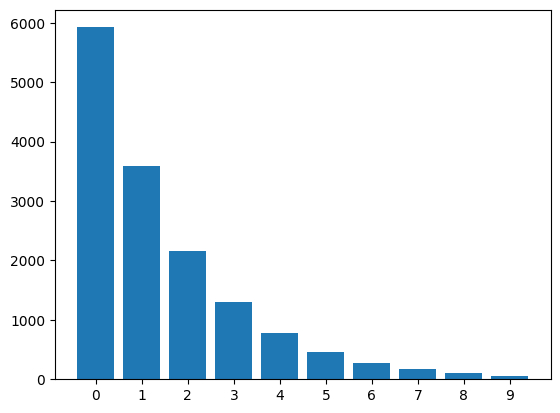

In [3]:
trainset = torchvision.datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1302,), (0.3069,)),
        ]
    ),
)


# generate imbalanced dataset
num_classes = 10
classe_labels = range(num_classes)
sample_probs = torch.rand(num_classes)
idx_to_remove = []


def get_img_num_per_cls(data, num_classes=10, imb_type="exp", imb_factor=0.01):
    img_max = len(data) / num_classes
    img_num_per_cls = []
    if imb_type == "exp":
        for cls_idx in range(num_classes):
            num = img_max * (imb_factor ** (cls_idx / (num_classes - 1.0)))
            img_num_per_cls.append(int(num))
    return img_num_per_cls


def gen_imbalanced_data(targets, img_num_per_cls):
    targets_np = np.array(targets, dtype=np.int64)
    classes = np.unique(targets_np)
    num_per_cls_dict = dict()
    idx_to_remove = []
    for the_class, the_img_num in zip(classes, img_num_per_cls):
        num_per_cls_dict[the_class] = the_img_num
        idx = np.where(targets_np == the_class)[0]
        np.random.shuffle(idx)
        selec_idx = idx[:the_img_num]
        idx_to_remove.extend(list(np.setdiff1d(idx, selec_idx)))
    return idx_to_remove


img_num_per_cls = get_img_num_per_cls(trainset)
idx_to_remove = gen_imbalanced_data(trainset.targets, img_num_per_cls)

# print('idx_to_remove: ', idx_to_remove)
imbalanced_train_dataset = copy.deepcopy(trainset)
imbalanced_train_dataset.targets = np.delete(trainset.targets, idx_to_remove, axis=0)
imbalanced_train_dataset.data = np.delete(trainset.data, idx_to_remove, axis=0)
print("Distribution of classes in Imbalanced dataset:")
print(Counter(imbalanced_train_dataset.targets.numpy()))
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_dataset.targets, return_counts=True)
ax.bar(range(10), counts)
ax.set_xticks(range(10))
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.show()

imbalanced_train_loader = torch.utils.data.DataLoader(
    imbalanced_train_dataset, batch_size=64, shuffle=True
)

Original dataset: 60000 training samples & 10000 testing samples

Distribution of classes in original dataset:


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


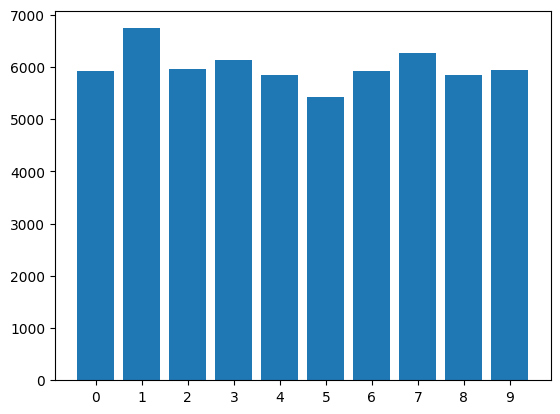

Sampling probability for each class:


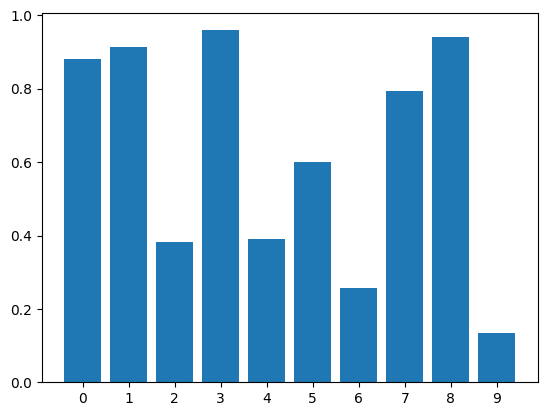

Imbalanced dataset: 14809 training samples & 10000 testing samples

Distribution of classes in imbalanced dataset:


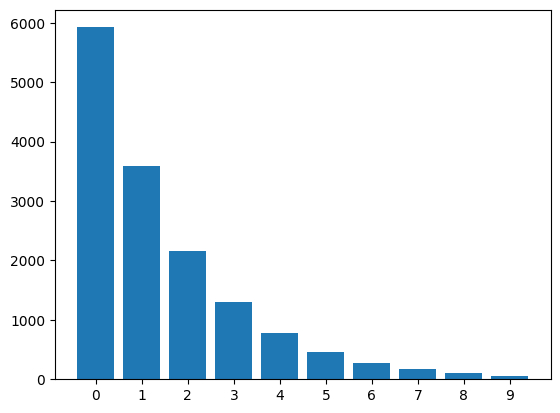

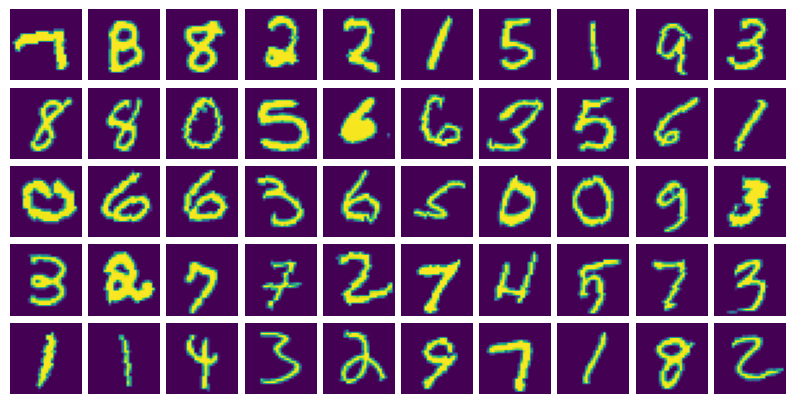

In [4]:
def show_mnist(arr, nrow=5, ncol=10, figsize=None):
    if figsize is None:
        figsize = (ncol, nrow)

    f, a = plt.subplots(nrow, ncol, figsize=figsize)

    def _do_show(the_figure, the_array):
        the_figure.imshow(the_array)
        the_figure.axis("off")

    for i in range(nrow):
        for j in range(ncol):
            _do_show(a[i][j], np.reshape(arr[i * ncol + j], (28, 28)))

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.draw()


def vis(test_accs, confusion_mtxes, labels, figsize=(20, 8)):
    cm = confusion_mtxes[np.argmax(test_accs)]
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ""
            else:
                annot[i, j] = "%.1f%%" % p
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = "Actual"
    cm.columns.name = "Predicted"

    fig = plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.plot(test_accs, "g")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=annot, fmt="", cmap="Blues", annot_kws={"size": 10})
    plt.show()
    return annot


print(
    "Original dataset: %d training samples & %d testing samples\n"
    % (len(train_loader.dataset), len(test_loader.dataset))
)

print("Distribution of classes in original dataset:")
fig, ax = plt.subplots()
_, counts = np.unique(train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.show()

print("Sampling probability for each class:")
fig, ax = plt.subplots()
ax.bar(classe_labels, sample_probs)
ax.set_xticks(classe_labels)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.show()

print(
    "Imbalanced dataset: %d training samples & %d testing samples\n"
    % (len(imbalanced_train_loader.dataset), len(test_loader.dataset))
)

print("Distribution of classes in imbalanced dataset:")
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)
plt.show()

for data, _ in train_loader:
    show_mnist(data)
    break

In [5]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = torch.nn.Dropout2d()
        self.fc1 = torch.nn.Linear(320, 50)
        self.fc2 = torch.nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
def process(train_loader, test_loader, lossCriterion, epochs=20, weight=None):
    model = Net().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

    criterion = lossCriterion(weight=weight)

    def train(train_loader):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    def test(test_loader):
        model.eval()
        correct = 0
        targets, preds = [], []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.max(1, keepdim=True)[
                    1
                ]  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

                targets += list(target.cpu().numpy())
                preds += list(pred.cpu().numpy())

        test_acc = 100.0 * correct / len(test_loader.dataset)
        confusion_mtx = sm.confusion_matrix(targets, preds)
        return test_acc, confusion_mtx

    test_accs, confusion_mtxes = [], []
    for epoch in range(0, epochs):
        train(train_loader)
        test_acc, confusion_mtx = test(test_loader)
        test_accs.append(test_acc)
        confusion_mtxes.append(confusion_mtx)
        print("\rBest test acc = %2.2f%%" % max(test_accs))

    confusion_mtx = vis(test_accs, confusion_mtxes, classe_labels)
    return test_accs[np.argmax(test_accs)], confusion_mtx

# Baseline using Cross Entropy Loss

Best test acc = 46.11%
Best test acc = 60.40%
Best test acc = 65.21%
Best test acc = 68.46%
Best test acc = 70.80%
Best test acc = 72.06%
Best test acc = 73.38%
Best test acc = 74.86%
Best test acc = 77.50%
Best test acc = 77.50%
Best test acc = 77.81%
Best test acc = 79.50%
Best test acc = 79.50%
Best test acc = 81.48%
Best test acc = 81.48%
Best test acc = 81.48%
Best test acc = 82.12%
Best test acc = 84.55%
Best test acc = 84.55%
Best test acc = 84.55%


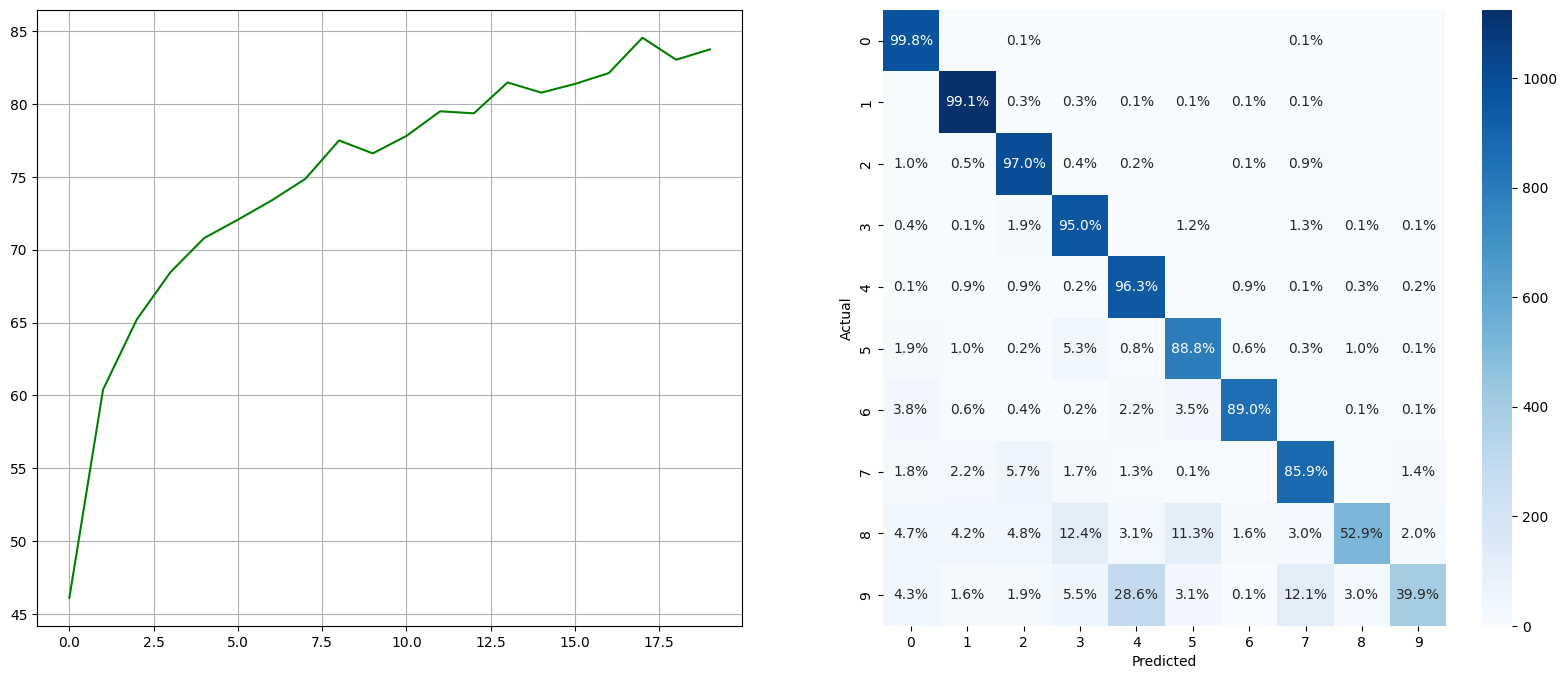

In [7]:
# baseline of torch.nn.CrossEntropyLoss
test_acc_crossentropy, confusion_mtx_crossentropy = process(
    imbalanced_train_loader, test_loader, torch.nn.NLLLoss
)

# Using class weights

In [8]:
# use the class_weights obtained using sklearn's compute_class_weight function
from sklearn.utils import class_weight

y = imbalanced_train_loader.dataset.targets
class_weights = class_weight.compute_class_weight(
    "balanced", classes=np.unique(y), y=y.numpy()
)
class_weights

array([ 0.25002533,  0.41181869,  0.68687384,  1.14620743,  1.91330749,
        3.19159483,  5.32697842,  8.92108434, 14.809     , 24.68166667])

In [9]:
# OR generate our own class_weights using the formula
from collections import Counter

y = imbalanced_train_loader.dataset.targets
class_weights = np.asarray(
    [len(y) / (cnt * num_classes) for _, cnt in sorted(Counter(y.numpy()).items())]
)
class_weights

array([ 0.25002533,  0.41181869,  0.68687384,  1.14620743,  1.91330749,
        3.19159483,  5.32697842,  8.92108434, 14.809     , 24.68166667])

Distribution of classes in imbalanced dataset:


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


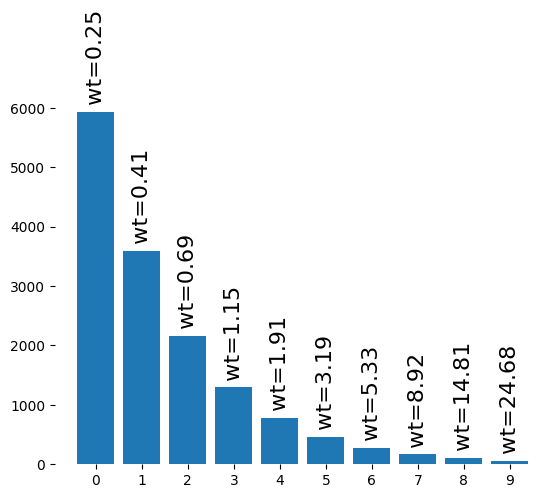

In [10]:
# random test cell; delete after use. | TODO: delete this cell
print("Distribution of classes in imbalanced dataset:")
fig, ax = plt.subplots()
_, counts = np.unique(imbalanced_train_loader.dataset.train_labels, return_counts=True)
ax.bar(classe_labels, counts)
ax.set_xticks(classe_labels)

rects = ax.patches
# Make some labels.
labels = [" wt=" + str(round(i, 2)) for i in class_weights]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height + 5,
        label,
        ha="center",
        va="bottom",
        rotation="vertical",
        fontsize=16,
    )

# ax.axis('off')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

plt.show()

Best test acc = 63.08%
Best test acc = 78.24%
Best test acc = 85.13%
Best test acc = 87.30%
Best test acc = 87.86%
Best test acc = 87.86%
Best test acc = 91.24%
Best test acc = 91.24%
Best test acc = 91.67%
Best test acc = 92.14%
Best test acc = 92.14%
Best test acc = 92.14%
Best test acc = 92.14%
Best test acc = 92.97%
Best test acc = 93.15%
Best test acc = 93.15%
Best test acc = 93.15%
Best test acc = 93.24%
Best test acc = 93.51%
Best test acc = 93.63%


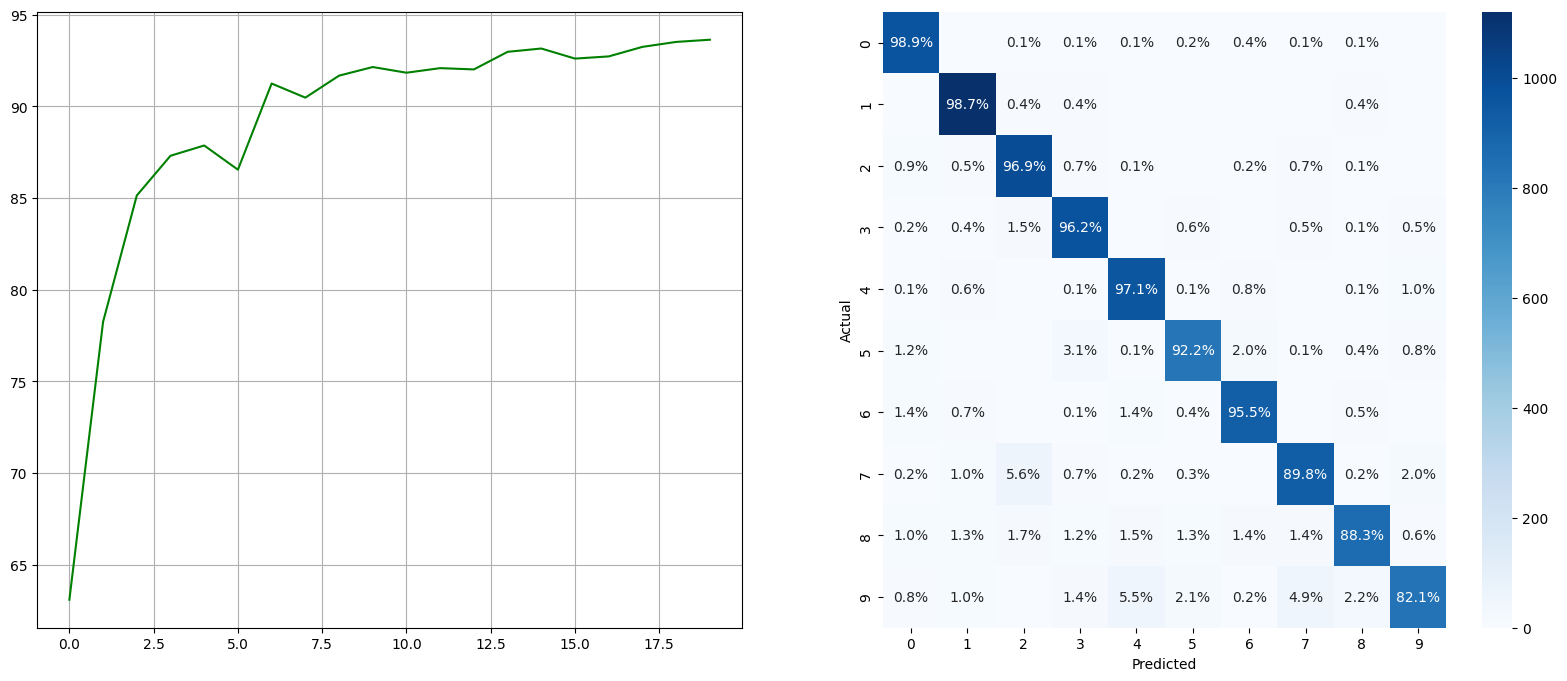

In [11]:
test_acc_crossentropy_weighted, confusion_mtx_crossentropy_weighted = process(
    imbalanced_train_loader,
    test_loader,
    lossCriterion=torch.nn.NLLLoss,
    weight=torch.from_numpy(class_weights).cuda(0).float(),
)

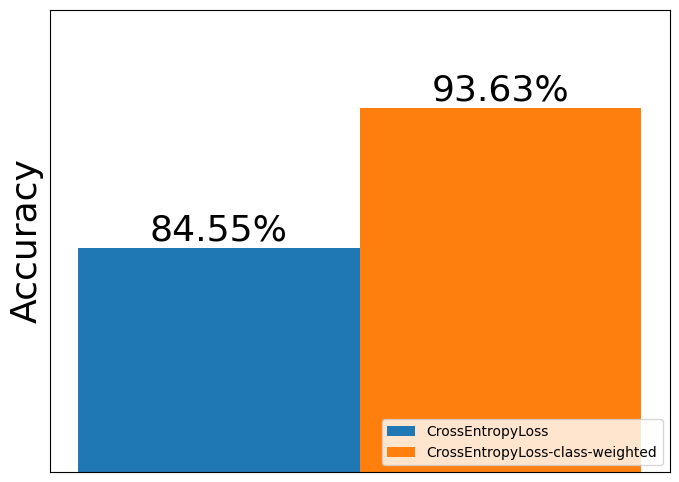

In [12]:
fig = plt.subplots(figsize=(8, 6))
# plt.rcParams['font.size'] = 26

br1 = np.arange(1)
br2 = [x + 0.1 for x in br1]

p1 = plt.bar(
    br1,
    np.array(test_acc_crossentropy).astype(float),
    width=0.1,
    label="CrossEntropyLoss",
)
p2 = plt.bar(
    br2,
    np.array(test_acc_crossentropy_weighted).astype(float),
    width=0.1,
    label="CrossEntropyLoss-class-weighted",
)

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=26,
    )
for rect1 in p2:
    height = rect1.get_height()
    plt.annotate(
        "{:.2f}%".format(height),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.05),
        ha="center",
        va="bottom",
        fontsize=26,
    )

plt.ylim(70, 100)
plt.tick_params(
    left=False, right=False, labelleft=False, labelbottom=False, bottom=False
)
plt.legend(loc="lower right")
plt.ylabel("Accuracy", fontsize=26)
plt.show()

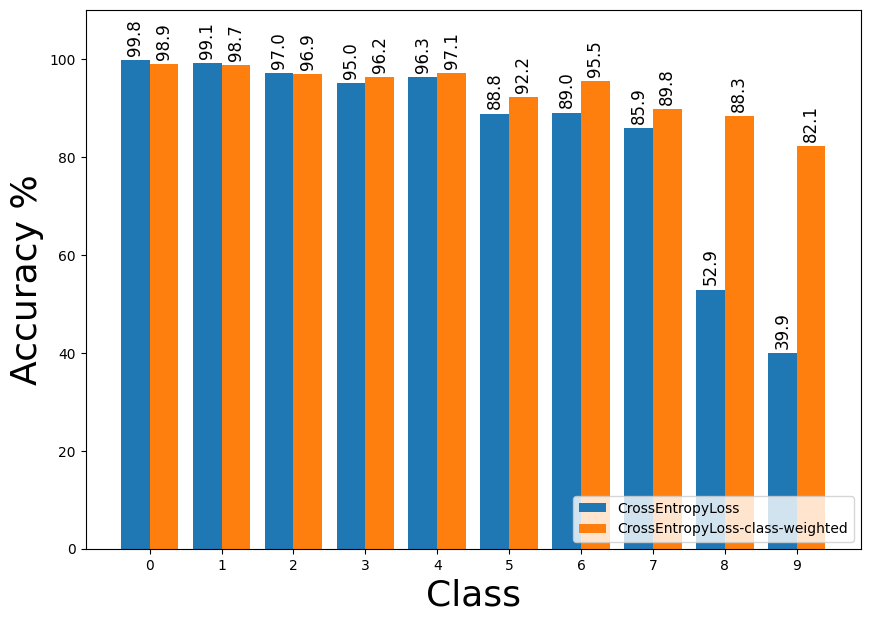

In [13]:
fig = plt.subplots(figsize=(10, 7))

br1 = np.arange(10)
br2 = [x + 0.4 for x in br1]
class_percentages_crossentropy = [
    confusion_mtx_crossentropy[i][i][:-1] for i in range(10)
]
class_percentages2_hardmining = [
    confusion_mtx_crossentropy_weighted[i][i][:-1] for i in range(10)
]

p1 = plt.bar(
    br1,
    np.array(class_percentages_crossentropy).astype(float),
    width=0.4,
    label="CrossEntropyLoss",
)
p2 = plt.bar(
    br2,
    np.array(class_percentages2_hardmining).astype(float),
    width=0.4,
    label="CrossEntropyLoss-class-weighted",
)

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate(
        "{:.1f}".format((height)),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.9),
        ha="center",
        va="bottom",
        fontsize=12,
        rotation="vertical",
    )
for rect1 in p2:
    height = rect1.get_height()
    plt.annotate(
        "{:.1f}".format((height)),
        (rect1.get_x() + rect1.get_width() / 2, height + 0.9),
        ha="center",
        va="bottom",
        fontsize=12,
        rotation="vertical",
    )

plt.xticks(
    [r + 0.2 for r in range(10)], ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
)
plt.ylim(0, 110)
plt.legend(loc="lower right")
plt.xlabel("Class", fontsize=26)
plt.ylabel("Accuracy %", fontsize=26)
plt.rc("xtick", labelsize=26)
plt.rc("ytick", labelsize=26)
plt.show()

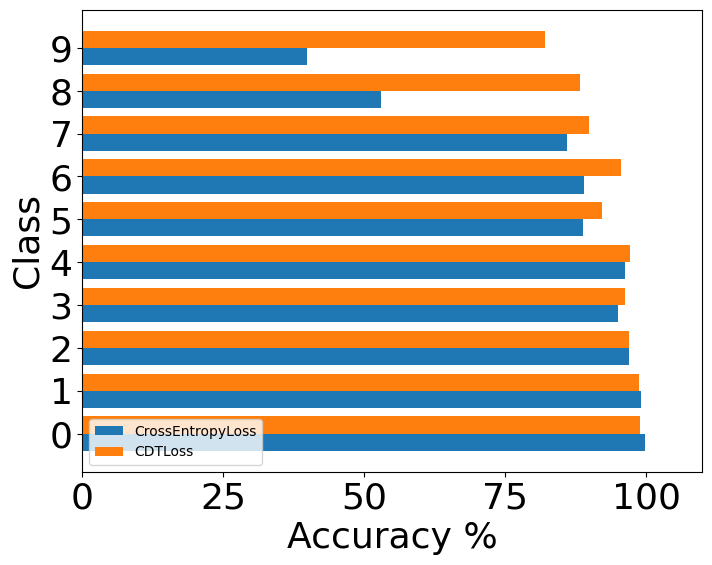

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

br1 = np.arange(10)
br2 = [x + 0.4 for x in br1]
class_percentages_crossentropy = [
    confusion_mtx_crossentropy[i][i][:-1] for i in range(10)
]
class_percentages_crossentropy_weighted = [
    confusion_mtx_crossentropy_weighted[i][i][:-1] for i in range(10)
]

p1 = plt.barh(
    br1,
    np.array(class_percentages_crossentropy).astype(float),
    height=0.4,
    label="CrossEntropyLoss",
)
p2 = plt.barh(
    br2,
    np.array(class_percentages_crossentropy_weighted).astype(float),
    height=0.4,
    label="CDTLoss",
)

plt.yticks(
    [r + 0.2 for r in range(10)],
    ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"],
    fontsize=26,
)
plt.xlim(0, 110)
plt.legend(loc="lower left")
plt.ylabel("Class", fontsize=26)
plt.xlabel("Accuracy %", fontsize=26)
plt.show()

In [15]:
df = pd.DataFrame(
    {
        "CrossEntropyLoss": class_percentages_crossentropy,
        "CDTLoss": class_percentages_crossentropy_weighted,
    },
    index=range(10),
)
df

,CrossEntropyLoss,CDTLoss
0,99.8,98.9
1,99.1,98.7
2,97.0,96.9
3,95.0,96.2
4,96.3,97.1
5,88.8,92.2
6,89.0,95.5
7,85.9,89.8
8,52.9,88.3
9,39.9,82.1
